In [1]:
import dgl
import dgl.nn as dglnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
def seed(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    dgl.random.seed(seed)
seed(0)

/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


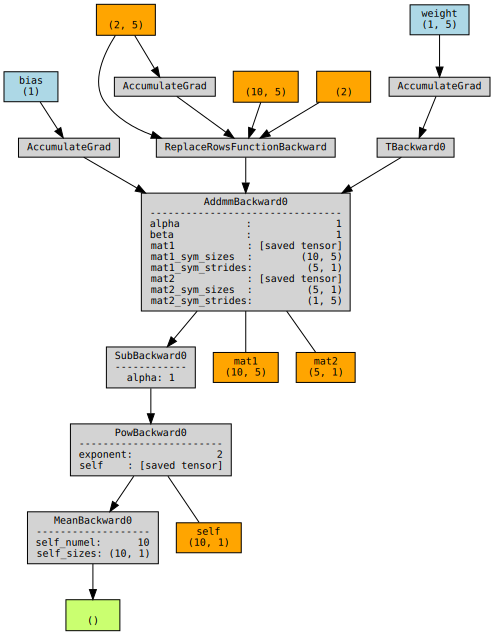

In [3]:
class ReplaceRowsFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, rows, replacement):
        ctx.save_for_backward(input, rows, replacement)
        output = input.clone()
        output[rows] = replacement
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, rows, replacement = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_replacement = grad_output[rows].clone()
        grad_input[rows] = 0
        return grad_input, None, grad_replacement
    
replace_rows = ReplaceRowsFunction.apply


feat = torch.randn(10, 5, requires_grad=False)
targets = torch.randn(10, 1)
rows_to_replace = torch.tensor([1, 3])


model = nn.Linear(5, 1)
optimizer = optim.SGD(model.parameters(), lr=0.01)

def simple_replace(feat, idx, replacements):
    feat[idx] = replacements
    return feat

model.train()
    # 使用自定义函数替换行
rows = torch.tensor([[1.0, 2.0, 3.0, 4.0, 5.0],
                    [4.0, 5.0, 6.0, 0.0, 1.0]], requires_grad=True)
feat_replaced = replace_rows(feat, rows_to_replace, rows)

# feat_replaced = feat.clone()
# feat_replaced = simple_replace(feat, rows_to_replace, rows)
# feat_replaced[rows_to_replace] = rows

# print(feat_replaced)

# 前向传播
outputs = model(feat_replaced)
loss = ((outputs - targets) ** 2).mean()
make_dot(loss, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)